# Distances

For this example notebook, we'll need to install Ripser.py to create the persistence diagrams:
```
pip install Cython ripser
```

In [1]:
from sklearn import datasets
import numpy as np
import persim
import persim.plot
import ripser
import matplotlib.pyplot as plt

In [2]:
data_clean = datasets.make_circles()[0]
data_noisy = datasets.make_circles(noise=0.1)[0]

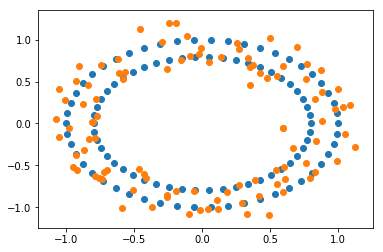

In [3]:
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data")
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data")

## Generate $H_1$ diagrams for each of the data sets

In [4]:
dgm_clean = ripser.ripser(data_clean)['dgms'][1]
dgm_noisy = ripser.ripser(data_noisy)['dgms'][1]

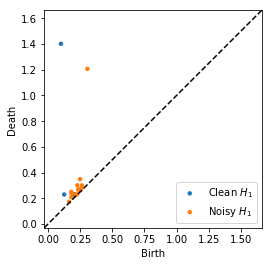

In [5]:
ripser.plot_dgms([dgm_clean, dgm_noisy] , labels=['Clean $H_1$', 'Noisy $H_1$'])

## Compute and visualize Bottleneck distance

The `bottleneck` function has the option of returning the matching when the parameter `matching` is set to `True`. With the returned data, we can use the `plot.bottleneck_matching` function to visualize which persistence points contributed to the distance.

In [6]:
distance_bottleneck, (matching, D) = persim.bottleneck(dgm_clean, dgm_noisy, matching=True)

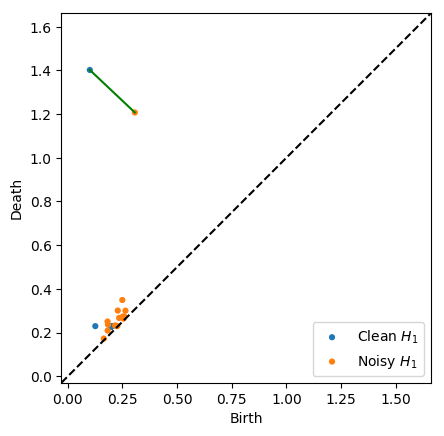

In [7]:
persim.plot.bottleneck_matching(dgm_clean, dgm_noisy, matching, D, labels=['Clean $H_1$', 'Noisy $H_1$'])

The default option of `matching=False` will return just the distance if that is all you're interested in.

In [8]:
persim.bottleneck(dgm_clean, dgm_noisy)

0.2060278281569481

Text(0.5, 1.0, 'Distance 0.100')

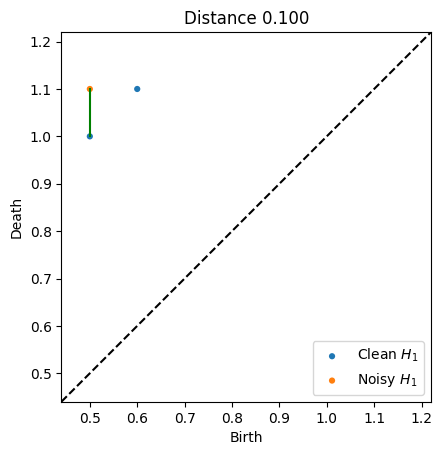

In [9]:
dgm1 = np.array([
    [0.5, 1],
    [0.6, 1.1]
])
dgm2 = np.array([
    [0.5, 1.1],
#     [0.7,0.8]
])

d, (matching, D) = persim.bottleneck(
    dgm1,
    dgm2,
    matching=True
)

persim.plot.bottleneck_matching(dgm1, dgm2, matching, D, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.title(f"Distance {d:.3f}")

In [10]:
matching, D

([(0, 0), (1, 1), (2, 2)], array([[0.1 , 0.25, 0.1 ],
        [0.1 , 0.1 , 0.25],
        [0.3 , 0.  , 0.  ]]))

## Sliced Wasserstein distance


Sliced Wasserstein Kernels for persistence diagrams were introduced by [Carriere et al, 2017](https://arxiv.org/abs/1706.03358) and implemented by Alice Patania.

The general idea is to compute an approximation of the Wasserstein distance by computing the distance in 1-dimension repeatedly, and use the results as measure. To do so, the points of each persistence diagram are projected onto M lines that pass through (0,0) and forms an angle theta with the axis x.

In [11]:
persim.sliced_wasserstein(dgm_clean, dgm_noisy)

0.9445603424817036

The parameter `M` controls the number of iterations to run

In [12]:
Ms = range(5, 100, 2)
ds = [persim.sliced_wasserstein(dgm_clean, dgm_noisy, M=M) for M in Ms]

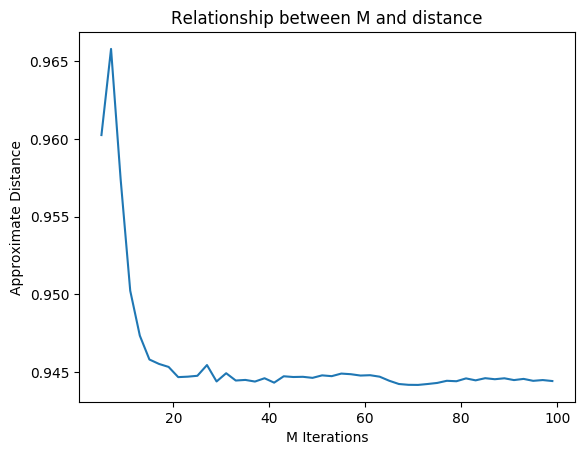

In [13]:
plt.plot(Ms, ds)
plt.xlabel("M Iterations")
plt.ylabel("Approximate Distance")
plt.title("Relationship between M and distance")
plt.show()

## Heat Kernel Distance

We also implement the heat kernel distance

In [14]:
persim.heat(dgm_clean, dgm_noisy)

0.31222031697773356

The parameter `sigma` controls the heat diffusion.

In [15]:
sigmas = np.linspace(0.1, 10, 100)
ds = [persim.heat(dgm_clean, dgm_noisy, sigma=s) for s in sigmas]

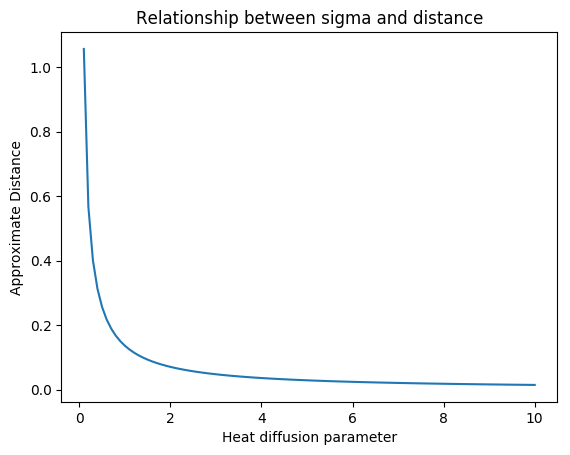

In [16]:
plt.plot(sigmas, ds)
plt.xlabel("Heat diffusion parameter")
plt.ylabel("Approximate Distance")
plt.title("Relationship between sigma and distance")
plt.show()